<a href="https://colab.research.google.com/github/hoangp/isbi-datasets/blob/upload_colab/CNN_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

fatal: destination path 'isbi-datasets' already exists and is not an empty directory.

FOLD 0


----------------------------------
Load and pre-process original data
----------------------------------

loading train-volume01.jpg and train-labels01.jpg ...
loading train-volume12.jpg and train-labels12.jpg ...
loading train-volume23.jpg and train-labels23.jpg ...
X_org : shape = (27, 128, 128, 1) , min = 2 , max = 252
y_org : shape = (27, 128, 128, 1) , min = 0 , max = 255
X_test: shape = (3, 128, 128, 1) , min = 1 , max = 247
y_test: shape = (3, 128, 128, 1) , min = 0 , max = 255

-------------------------
Generate augmented images
-------------------------

Generate augmented data for data & label array 0 ...
Generate augmented data for data & label array 10 ...
Generate augmented data for data & label array 20 ...
No. of augmented images = 1723 (saved to isbi-datasets/output/aug)

---------------------------------------------------------
Create train data from original data and augmen

W0730 12:35:02.059814 140144159651712 util.py:61] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0730 12:35:02.063116 140144159651712 util.py:61] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0730 12:35:02.066317 140144159651712 util.py:61] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Saving 3 images to isbi-datasets/output/results
Convert test data to float32 range 0..1
3/3 [==============================] - 0s 7ms/step
Saving 3 images to isbi-datasets/output/results

-----------------
Visualize results
-----------------



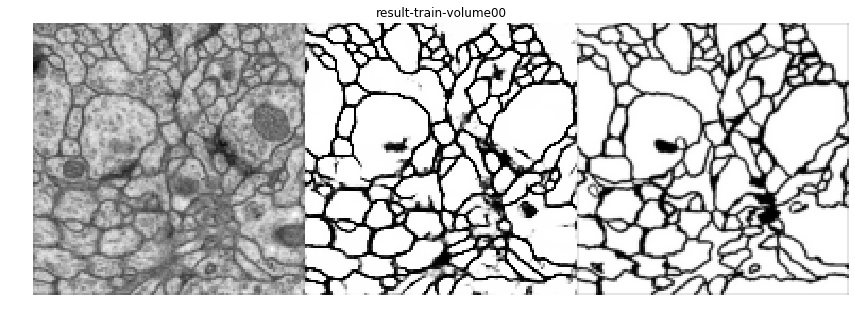

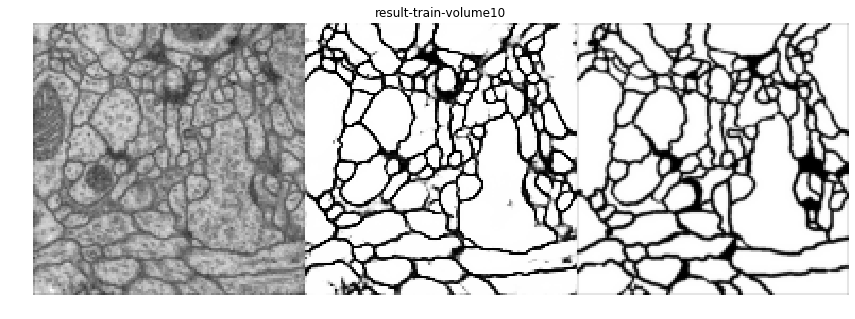

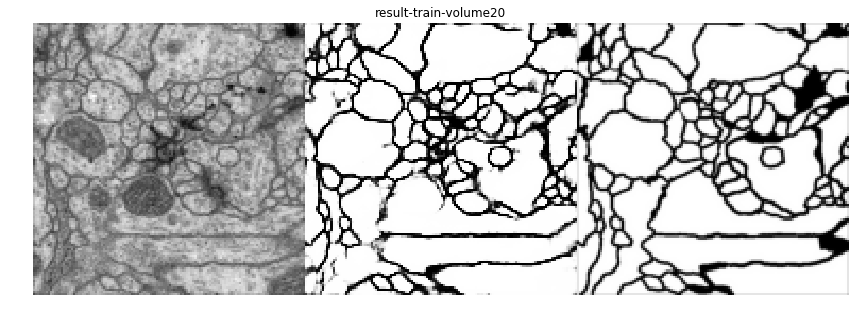

In [3]:
!git clone https://github.com/hoangp/isbi-datasets.git

!rm -rf isbi-datasets/output
!mkdir -p isbi-datasets/output
!mkdir -p isbi-datasets/output/aug
!mkdir -p isbi-datasets/output/models
!mkdir -p isbi-datasets/output/results

import os
import glob
import random
import numpy as np
import matplotlib.pyplot as plt
import skimage.io as io
from skimage.transform import resize
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from keras.layers import *

# PARAMETERS
project_path = 'isbi-datasets'
data_train_path = project_path + '/data/images'
data_label_path = project_path + '/data/labels'
output_path     = project_path + '/output'
aug_path        = output_path + '/aug' 

image_size = 512
target_size = 128     # smaller target_size for quicker training
num_aug_batches = 64  # total augmented images = num_imgs * num_aug_batches
train_batch_size = 4 
train_epochs = 10
fn = 0 # cross validation fold (from 0 to 9)

    
# define model
class UNet:
    def __init__(self, target_size = None):
        self.target_size = target_size
        self.model = None
        if target_size:
            self.model = self._get_unet()
        
        self.batch_size = None
        self.model_save_path = output_path + '/models'
        self.result_save_path = output_path + '/results'

    def _get_unet(self):
        from keras.models import Model
        from keras.optimizers import Adam
        inputs = Input((self.target_size, self.target_size,1))
        conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
        conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
        pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
        conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
        conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
        pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
        conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
        conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
        pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
        conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
        conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
        drop4 = Dropout(0.5)(conv4)
        pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
        conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
        conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
        drop5 = Dropout(0.5)(conv5)
        up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
        merge6 = concatenate([drop4,up6],axis = 3)
        conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
        conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)
        up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
        merge7 = concatenate([conv3,up7],axis = 3)
        conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
        conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
        up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
        merge8 = concatenate([conv2,up8],axis = 3)
        conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
        conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
        up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
        merge9 =concatenate([conv1,up9],axis = 3)
        conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
        conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
        conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
        conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)
        model = Model(inputs = inputs, outputs = conv10)
        model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
        return model
    
    def disp_summary(self):
        seld.model.summary()
        
    def train(self, X_train, y_train, batch_size, epochs):
        # Trains the model for a given number of epochs (iterations on a dataset).
        # fit(x=None, y=None, batch_size=None, epochs=1, verbose=1, callbacks=None, 
        #     validation_split=0.0, validation_data=None, shuffle=True, class_weight=None, 
        #     sample_weight=None, initial_epoch=0, steps_per_epoch=None, validation_steps=None, validation_freq=1)
        # batch_size: Number of samples per gradient update. If unspecified, batch_size will default to 32.
        # verbose: Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch.
        # (https://keras.io/models/model/) 
        
        save_name = 'unet' + '.shape-' + str(target_size) + \
                             '.train-' + str(len(X_train)) + \
                             '.batch-' + str(batch_size) + \
                             '.epoch-' + str(epochs)
        
        from keras.callbacks import ModelCheckpoint
        model_checkpoint = ModelCheckpoint(self.model_save_path + '/' + save_name + '.hdf5', 
                                           monitor='loss', verbose=1, save_best_only=True)       
        self.model.fit(X_train, y_train, batch_size, epochs, 
                       validation_split=0.2, shuffle=True, callbacks=[model_checkpoint])
        
    def predict(self, X_test):
        if np.max(X_test) > 1:
            print("Convert test data to float32 range 0..1")
            X_test = X_test.astype(np.float32) / 255.0
        return self.model.predict(X_test, batch_size=self.batch_size, verbose=1)
    
    def predict_and_save(self, X_test, save_names = None, save_format = 'jpg'):
        y_pred = self.predict(X_test)   
        print('Saving ' + str(len(y_pred)) + ' images to ' + self.result_save_path)       
        for i in range(len(y_pred)):
            save_name = save_names[i] if save_names else str(i)
            io.imsave(self.result_save_path + "/" + save_name + "." + save_format, y_pred[i])       
        return y_pred
        
    def load(self, filepath):         
        # extract model info from filename
        s_path   = filepath.split('/')
        s_name   = s_path[-1].split('.')  # ['unet', 'shape-128', 'train-700', 'batch-4', 'epoch-5', 'hdf5']
        s_target = s_name[1].split('-')   # ['shape', '128']
        s_batch  = s_name[3].split('-')   # ['batch', '4']
        self.target_size = int(s_target[1])
        self.batch_size  = int(s_batch[1])
        
        print('loading model ' +  s_path[-1] + ' ...')     
        
        from keras.models import load_model
        self.model = load_model(filepath)   
        

# get data
data_train_filenames = glob.glob(data_train_path + "/*.jpg")
data_label_filenames = glob.glob(data_label_path + "/*.jpg")
data_train_filenames.sort()
data_label_filenames.sort()

# setup cross validation folds
folds = []
for i in range(10):
    fold = {}
    test_index = [0+i, 10+i, 20+i]
    fold['test_index'] = test_index
    fold['train_filenames'] = [data_train_filenames[k] for k in range(len(data_train_filenames)) if not k in test_index]
    fold['label_filenames'] = [data_label_filenames[k] for k in range(len(data_label_filenames)) if not k in test_index]
    fold['test_filenames'] = [data_train_filenames[k] for k in range(len(data_train_filenames)) if k in test_index]
    fold['test_label_filenames'] = [data_label_filenames[k] for k in range(len(data_label_filenames)) if k in test_index]
    fold['result_names'] = ['result-' + fold['test_filenames'][k].split('/')[-1].split('.')[0] for k in range(len(fold['test_filenames']))]
    folds.append(fold)

print('\n======')
print('FOLD',fn)
print('======\n')
        
print('\n----------------------------------')
print('Load and pre-process original data')
print('----------------------------------\n')

# get data images and labels filenames
train_filenames = folds[fn]['train_filenames'] 
label_filenames = folds[fn]['label_filenames'] 
test_filenames = folds[fn]['test_filenames'] 
test_label_filenames = folds[fn]['test_label_filenames'] 

# get train data
X_org = np.ndarray((len(train_filenames), target_size, target_size, 1), dtype=np.uint8)
y_org = np.ndarray((len(train_filenames), target_size, target_size, 1), dtype=np.uint8)
for i in range(len(train_filenames)):
    arr_t = img_to_array(load_img(train_filenames[i], color_mode = "grayscale"))
    arr_l = img_to_array(load_img(label_filenames[i], color_mode = "grayscale"))
    if i % 10 == 0:
        print('loading', train_filenames[i].split('/')[-1], 'and', 
                         label_filenames[i].split('/')[-1], '...')
    # resize for faster training
    if target_size < image_size:
        arr_t = resize(arr_t, (target_size, target_size, 1), 
                       mode = 'constant', preserve_range = True)
        arr_l = resize(arr_l, (target_size, target_size, 1), 
                       mode = 'constant', preserve_range = True)        
    X_org[i] = arr_t
    y_org[i] = arr_l

# get test data
X_test = np.ndarray((len(test_filenames), target_size, target_size, 1), dtype=np.uint8)
y_test = np.ndarray((len(test_filenames), target_size, target_size, 1), dtype=np.uint8)
for i in range(len(test_filenames)):
    arr_t = img_to_array(load_img(test_filenames[i], color_mode = "grayscale"))
    arr_l = img_to_array(load_img(test_label_filenames[i], color_mode = "grayscale"))
    # resize for faster training
    if target_size < image_size:
        arr_t = resize(arr_t, (target_size, target_size, 1), 
                       mode = 'constant', preserve_range = True)
        arr_l = resize(arr_l, (target_size, target_size, 1), 
                       mode = 'constant', preserve_range = True)        
    X_test[i] = arr_t
    y_test[i] = arr_l

print('X_org : shape =', X_org.shape, ', min =', np.min(X_org), ', max =', np.max(X_org))
print('y_org : shape =', y_org.shape, ', min =', np.min(y_org), ', max =', np.max(y_org))
print('X_test: shape =', X_test.shape, ', min =', np.min(X_test), ', max =', np.max(X_test))
print('y_test: shape =', y_test.shape, ', min =', np.min(y_test), ', max =', np.max(y_test))

print('\n-------------------------')
print('Generate augmented images')
print('-------------------------\n')

datagen = ImageDataGenerator(rotation_range=10, shear_range=0.1,  zoom_range=0.1,
     horizontal_flip=True, vertical_flip=True, fill_mode='constant', cval=0)

# merge label and train, one by one augmentation
for i in range(len(X_org)):
    arr_t = X_org[i]
    arr_l = y_org[i]

    s = np.shape(arr_t) # either image_size or target_size

    # Create data & label arrays for ImageDataGenerator.flow()
    arr_tl = np.ndarray(shape=(s[0],s[1],3), dtype=np.uint8) # (size, size, 3)
    arr_tl[:,:,0] = arr_t[:,:,0]
    arr_tl[:,:,2] = arr_l[:,:,0]
    arr_tl = arr_tl.reshape((1,) + arr_tl.shape) # (1, size, size, 3) -> Rank 4

    if i % 10 == 0:
        print("Generate augmented data for data & label array " + str(i) + " ...")

    # Takes data & label arrays, generates batches of augmented data.
    # flow(x, y=None, batch_size=32, shuffle=True, sample_weight=None, seed=None, 
    #      save_to_dir=None, save_prefix='', save_format='png', subset=None)
    batches = 0
    for batch in datagen.flow(arr_tl, batch_size=1, save_to_dir=aug_path, save_prefix=str(i)):
        batches += 1
        if batches >= num_aug_batches:
            break
            # we need to break the loop by hand because
            # the generator loops indefinitely       

aug_filenames = glob.glob(aug_path + "/*.*")
aug_filenames.sort()

print("No. of augmented images =", len(aug_filenames), "(saved to " + aug_path + ")")

print('\n---------------------------------------------------------')
print('Create train data from original data and augmented images')
print('---------------------------------------------------------\n')

X_train = np.ndarray((len(X_org) + len(aug_filenames), target_size, target_size, 1), dtype=np.float32)
y_train = np.ndarray((len(X_org) + len(aug_filenames), target_size, target_size, 1), dtype=np.float32)

# Use X_org and y_org as train data
print("loading X_org/y_org as training data ...")
for i in range(len(X_org)):
    X_train[i] = X_org[i]
    y_train[i] = y_org[i]

# Load images from augmentation folder
for i in range(len(aug_filenames)):
    if i % 100 == 0:
        print("loading augmented image " + str(i) + " ...")
    arr = img_to_array(load_img(aug_filenames[i]))
    X_train[len(X_org) + i] = arr[:,:,:1]
    y_train[len(X_org) + i] = arr[:,:,2:]

# convert X_train / y_train to 0..1
X_train /= 255.0
y_train /= 255.0

# convert y_train to 0 or 1
y_train[y_train > 0.5] = 1
y_train[y_train <= 0.5] = 0

print('X_train: shape =', X_train.shape, ', min =', np.min(X_train), ', max =', np.max(X_train))
print('y_train: shape =', y_train.shape, ', min =', np.min(y_train), ', max =', np.max(y_train))

# Load model
model = UNet(target_size)

print('\n-----')
print('TRAIN')
print('-----\n')

model.train(X_train, y_train, batch_size=train_batch_size, epochs=train_epochs)

print('\n--------------------------------')
print('Predict and save results to disk')
print('--------------------------------\n')

y_pred = model.predict_and_save(X_test, save_names = folds[fn]['result_names'], save_format = 'jpg')
y_pred = model.predict_and_save(X_test, save_names = folds[fn]['result_names'], save_format = 'tif')

print('\n-----------------')
print('Visualize results')
print('-----------------\n')

for i in range(len(X_test)):
    img_t = array_to_img(X_test[i])
    img_p = array_to_img(y_pred[i])
    img_l = array_to_img(y_test[i])

    plt.figure(i, figsize=(15, 5))
    plt.imshow(np.hstack((img_t, img_p, img_l)), cmap='gray')
    plt.title(folds[fn]['result_names'][i])
    plt.axis('off')